In [1]:
import glob
import os
import shutil
from PIL import Image 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import nibabel as nib

from modules.scandata import MriScan, MriSlice, TumourSegmentation, ScanType, ScanPlane

In [2]:
T1_img = nib.load('data/mri-datasets/first-20-testset/images_structural/UPENN-GBM-00002_11/UPENN-GBM-00002_11_T1.nii.gz')
seg = nib.load('data/mri-datasets/first-20-testset/AutoSeg/UPENN-GBM-00002_11_automated_approx_segm.nii.gz')

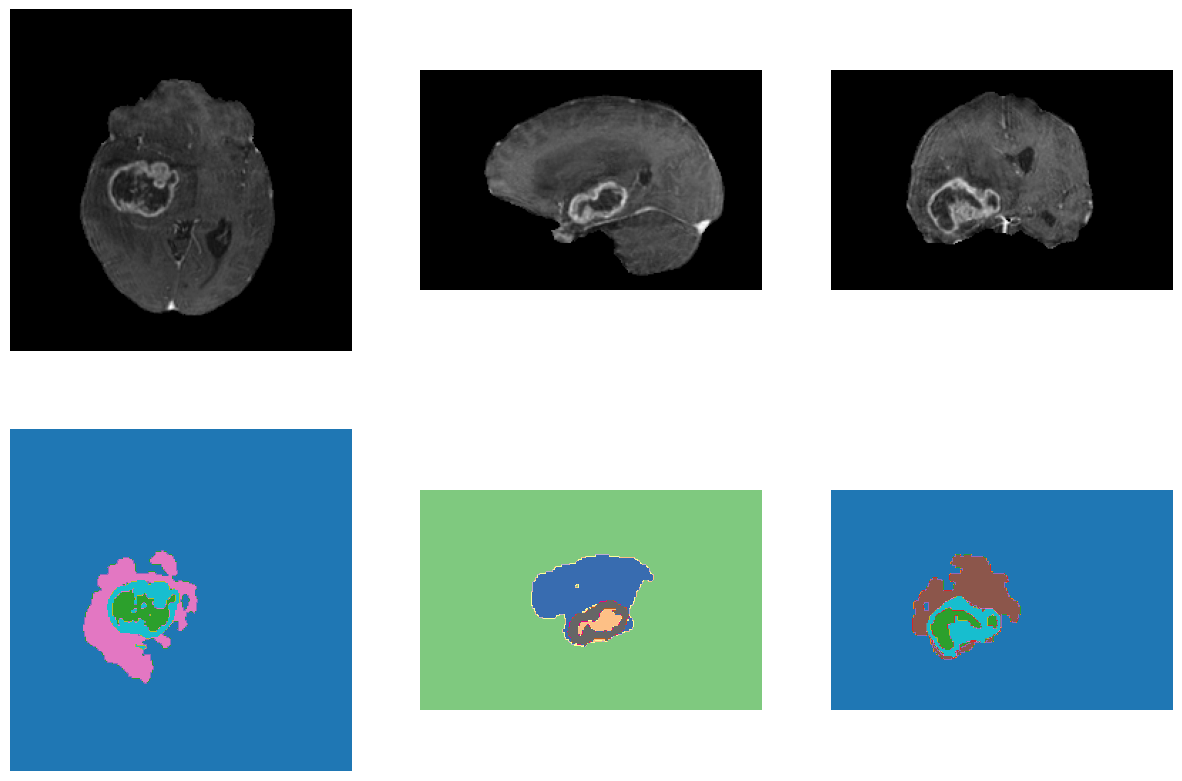

In [3]:
mri_scan = MriScan(
    filename='data/mri-datasets/first-20-testset/images_structural/UPENN-GBM-00002_11/UPENN-GBM-00002_11_T1GD.nii.gz',
    sequence=ScanType.T1CE
)
seg = TumourSegmentation('data/mri-datasets/first-20-testset/AutoSeg/UPENN-GBM-00002_11_automated_approx_segm.nii.gz')
fig, axes = plt.subplots(2,3,figsize=(15, 10))

trans = mri_scan.get_slice(slice_number=64, plane=ScanPlane.TRANSVERSAL)
trans.slice_data = trans.slice_data.T
trans.add_plot_to_axis(axes[0][0])

sag = mri_scan.get_slice(slice_number=102, plane=ScanPlane.SAGITTAL)
sag.slice_data = np.flip(sag.slice_data, 1).T
sag.add_plot_to_axis(axes[0][1])

cor = mri_scan.get_slice(slice_number=120, plane=ScanPlane.FRONTAL)
cor.slice_data = np.flip(cor.slice_data, 1).T
cor.add_plot_to_axis(axes[0][2])

discrete_cmap = plt.get_cmap('tab10', 6)

strans = seg.get_slice(slice_number=64, plane=ScanPlane.TRANSVERSAL)
strans.slice_data = strans.slice_data.T
strans.add_plot_to_axis(axes[1][0], cmap=discrete_cmap)

ssag = seg.get_slice(slice_number=102, plane=ScanPlane.SAGITTAL)
ssag.slice_data = np.flip(ssag.slice_data, 1).T
ssag.add_plot_to_axis(axes[1][1], cmap='Accent')

scor = seg.get_slice(slice_number=120, plane=ScanPlane.FRONTAL)
scor.slice_data = np.flip(scor.slice_data, 1).T
scor.add_plot_to_axis(axes[1][2], cmap='tab10')


[[ax1.set_axis_off() for ax1 in ax2] for ax2 in axes];



In [4]:
for nifti_file in glob.glob('data/mri-datasets/first-20-testset/images_structural/*/*_FLAIR.nii.gz'):
    mri_scan = MriScan(nifti_file, ScanType.FLAIR)
    mri_scan.save_png(nifti_file.removesuffix('.nii.gz'))

In [5]:
data_list = []
for auto_seg in glob.glob('data/mri-datasets/first-20-testset/AutoSeg/UPENN-GBM-*_11_automated_approx_segm.nii.gz'):
    patient = auto_seg.removeprefix('data/mri-datasets/first-20-testset/AutoSeg/UPENN-GBM-')[:5]
    segmentation = TumourSegmentation(auto_seg)
    for idx, slice in enumerate(segmentation.iterate_slices()):
        data_list.append([patient, idx, 0 if slice.slice_data.max()==0 else 1])


In [6]:
df = pd.DataFrame(data_list, columns=['patient', 'slice', 'tumour_present'])

In [7]:
print(df)


     patient  slice  tumour_present
0      00018      0               0
1      00018      1               0
2      00018      2               0
3      00018      3               0
4      00018      4               0
...      ...    ...             ...
3095   00014    150               0
3096   00014    151               0
3097   00014    152               0
3098   00014    153               0
3099   00014    154               0

[3100 rows x 3 columns]


In [29]:
data_dir = os.path.join('data','mri','datasets','first-20-testset','dataset')
tumour_data_dir = os.path.join(data_dir, 'tumour')
healthy_data_dir = os.path.join(data_dir, 'healthy')
try:
    os.mkdir(data_dir)
except FileExistsError:
    print('Directory exists')
try:
    os.mkdir(tumour_data_dir)
except FileExistsError:
    print('Directory exists')
try:
    os.mkdir(healthy_data_dir)
except FileExistsError:
    print('Directory exists')

Directory exists
Directory exists
Directory exists


In [9]:
# Arrange data set in directories for different classes
for idx, row in df.iterrows():
    patient_number = row['patient']
    slice_number = row['slice']
    original_file = f'data/mri-datasets/first-20-testset/images_structural/UPENN-GBM-{patient_number}_11/UPENN-GBM-{patient_number}_11_FLAIR_{slice_number:03}.png'
    filename = os.path.basename(original_file)
    if row['tumour_present']:
        new_file = os.path.join(tumour_data_dir, filename)
    else:
        new_file = os.path.join(healthy_data_dir, filename)
    shutil.copyfile(original_file, new_file)
        

In [10]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [11]:
batch_size = 32
img_height = 240
img_width = 240

In [12]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    color_mode="grayscale",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 3100 files belonging to 2 classes.
Using 2480 files for training.
Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-11-14 16:56:56.937350: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-14 16:56:56.937766: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [13]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    color_mode="grayscale",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 3100 files belonging to 2 classes.
Using 620 files for validation.


In [14]:
class_names = train_ds.class_names
print(class_names)

['healthy', 'tumour']


In [15]:
train_ds.list_files

<function tensorflow.python.data.ops.dataset_ops.DatasetV2.list_files(file_pattern, shuffle=None, seed=None, name=None)>

2022-11-14 16:57:07.387589: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


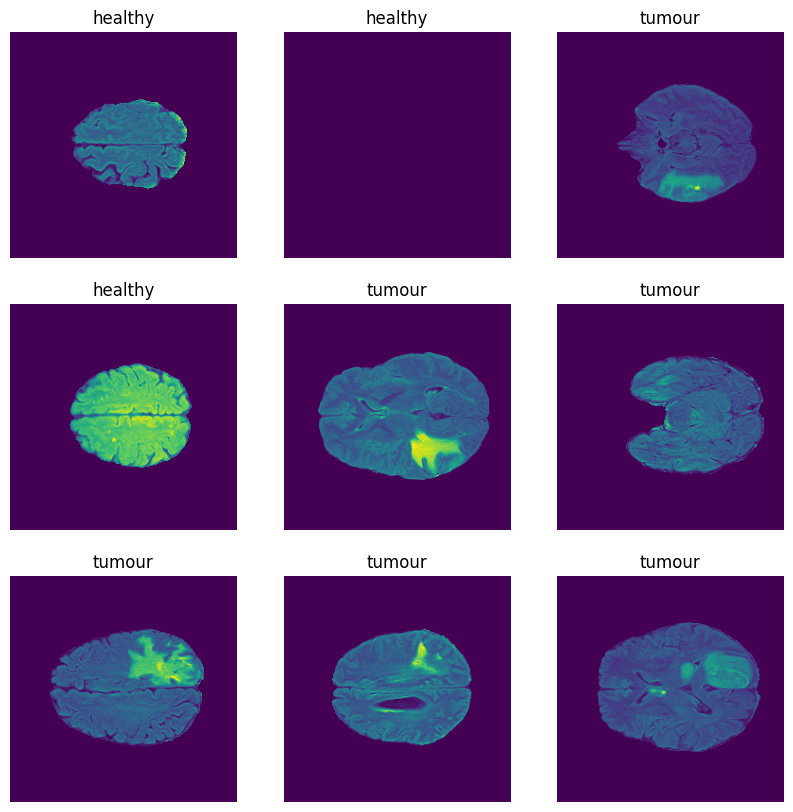

In [16]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [17]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 240, 240, 1)
(32,)


In [18]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [19]:
normalization_layer = layers.Rescaling(1./(2**16-1))

In [24]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./(2**16-1), input_shape=(img_height, img_width, 1)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [25]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 240, 240, 1)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 240, 240, 16)      160       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 120, 120, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 120, 120, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 60, 60, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 64)       

In [27]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


2022-11-14 16:59:08.043737: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


78/78 [==============================] - ETA: 0s - loss: 0.6796 - accuracy: 0.5911

2022-11-14 16:59:20.091612: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


78/78 [==============================] - 13s 149ms/step - loss: 0.6796 - accuracy: 0.5911 - val_loss: 0.6768 - val_accuracy: 0.5903
Epoch 2/10
78/78 [==============================] - 11s 147ms/step - loss: 0.6775 - accuracy: 0.5952 - val_loss: 0.6777 - val_accuracy: 0.5903
Epoch 3/10
78/78 [==============================] - 12s 148ms/step - loss: 0.6771 - accuracy: 0.5952 - val_loss: 0.6770 - val_accuracy: 0.5903
Epoch 4/10
78/78 [==============================] - 11s 143ms/step - loss: 0.6774 - accuracy: 0.5952 - val_loss: 0.6768 - val_accuracy: 0.5903
Epoch 5/10
78/78 [==============================] - 11s 145ms/step - loss: 0.6771 - accuracy: 0.5952 - val_loss: 0.6768 - val_accuracy: 0.5903
Epoch 6/10
78/78 [==============================] - 12s 148ms/step - loss: 0.6755 - accuracy: 0.5952 - val_loss: 0.6768 - val_accuracy: 0.5903
Epoch 7/10
78/78 [==============================] - 11s 144ms/step - loss: 0.6752 - accuracy: 0.5952 - val_loss: 0.6768 - val_accuracy: 0.5903
Epoch 8/10

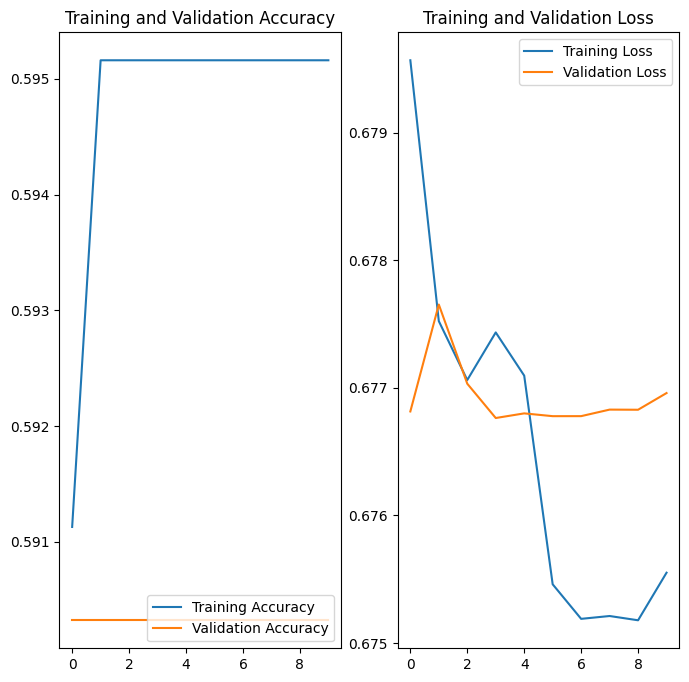

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()